In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
from itertools import chain
import os
import random
import zipfile
plt.style.use("ggplot")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
import seaborn as sns   #←これを追加
import timm    #←これを追加
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [2]:
class CFG:

                       # No. of epochs for training the model
  # Training settings
  batch_size = 25
  epochs = 20
  lr = 3e-5
  gamma = 0.7
  seed = 42                      # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/path/to/image"




# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [3]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)


In [4]:
from pathlib import Path
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [5]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = Image.open(imgpath).convert(mode="RGB")

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [6]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

In [7]:
import albumentations

In [8]:
test_transformer= transforms.Compose([
    transforms.Resize(CFG.img_size),
    transforms.ToTensor(),
])

In [9]:
test=Dataset(test_dir,test_transformer)

In [10]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [11]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=3)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    

In [12]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=CFG.gamma)

In [13]:
import time
from tqdm import tqdm
import time
import copy

In [14]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [15]:
classes=['A','B','C']

In [16]:
def test_eval(model):
  test_loss = 0.0
  correct_num=0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()
  test_loader=DataLoader(test,batch_size=CFG.batch_size,num_workers=25)

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      correct_num+=torch.sum(correct_tensor)
      for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  test_acc=correct_num/len(test_loader.dataset)
  # print('Test acc: {:.6f}\n'.format(test_acc))
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [17]:
import gc

In [18]:
for i in range(5):
    model.load_state_dict(torch.load(f'./weights/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    test_eval(model)

100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Test Loss: 0.721884

Test Accuracy of     A: 60% (60/100)
Test Accuracy of     B: 56% (56/100)
Test Accuracy of     C: 80% (80/100)

Test Accuracy (Overall): 65.3333 (196.0/300.0)


100%|██████████| 12/12 [00:03<00:00,  3.18it/s]


Test Loss: 0.669584

Test Accuracy of     A: 86% (86/100)
Test Accuracy of     B: 49% (49/100)
Test Accuracy of     C: 77% (77/100)

Test Accuracy (Overall): 70.6667 (212.0/300.0)


100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


Test Loss: 0.703140

Test Accuracy of     A: 95% (95/100)
Test Accuracy of     B: 28% (28/100)
Test Accuracy of     C: 80% (80/100)

Test Accuracy (Overall): 67.6667 (203.0/300.0)


100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


Test Loss: 0.704282

Test Accuracy of     A: 83% (83/100)
Test Accuracy of     B: 60% (60/100)
Test Accuracy of     C: 69% (69/100)

Test Accuracy (Overall): 70.6667 (212.0/300.0)


100%|██████████| 12/12 [00:03<00:00,  3.14it/s]

Test Loss: 0.691779

Test Accuracy of     A: 55% (55/100)
Test Accuracy of     B: 65% (65/100)
Test Accuracy of     C: 77% (77/100)

Test Accuracy (Overall): 65.6667 (197.0/300.0)


In [19]:
models=[]
for i in range(5):
    model.load_state_dict(torch.load(f'./weights/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    models.append(model)

In [20]:
def get_all_preds_k_fold(models,loader):
  all_preds=torch.tensor([])
  ground_truth=torch.tensor([])
  running_loss=0
  model1=models[0]
  model2=models[1]
  model3=models[2]
  model4=models[3]
  model5=models[4]
  for batch in loader:
    images,labels=batch
    images=images.to(device)
    labels=labels.to('cpu')

    ground_truth=torch.cat((ground_truth,labels),dim=0)
    p1=model1(images).to('cpu')
    p2=model2(images).to('cpu')
    p3=model3(images).to('cpu')
    p4=model4(images).to('cpu')
    p5=model5(images).to('cpu')
    preds=(p1+p2+p3+p4+p5)/5

    all_preds=torch.cat((all_preds,preds),dim=0)
    loss_val = criterion(preds, labels)
    running_loss += loss_val.item() * images.size(0)
  
  loss=running_loss/len(loader)
  return all_preds,ground_truth,loss

In [21]:
from random import shuffle
with torch.no_grad():
      prediction_loader=torch.utils.data.DataLoader(test,batch_size=len(test),num_workers=16,shuffle=False)
      test_preds,ground_truth,loss=get_all_preds_k_fold(models,prediction_loader)

In [22]:
def get_num_correct(preds,labels):
  print(preds.argmax(dim=1).eq(labels).sum().item()/len(preds))
get_num_correct(test_preds,ground_truth)

0.6566666666666666


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ground_truth,test_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


In [24]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=30,horizontalalignment="center", color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


/tmp/ipykernel_34338/63287085.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


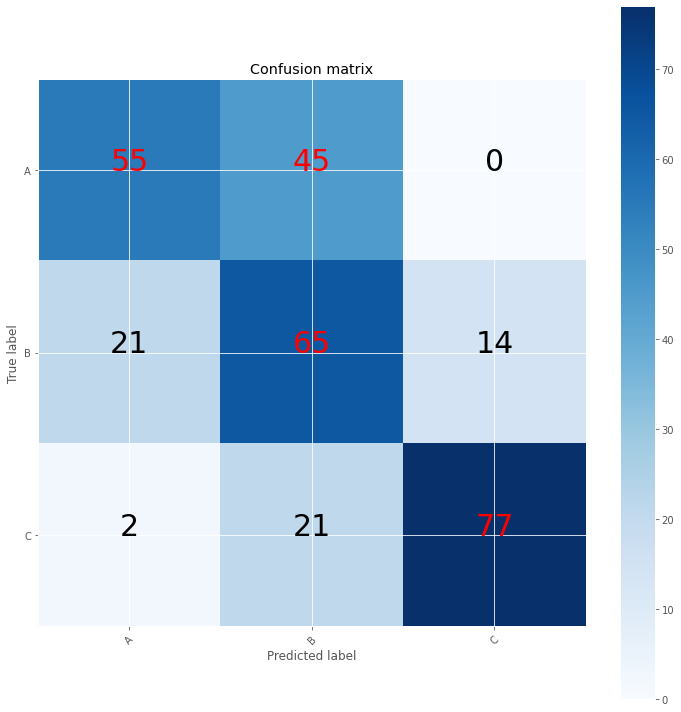

In [25]:
names=('A','B','C')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)